In [8]:
# Requesting and receiving data from Arduino v2

"""
Code based on code from:
https://be189.github.io/lessons/10/control_of_arduino_with_python.html
https://be189.github.io/lessons/11/control_with_buttons.html
"""

# NOTE:
# This will not work if the Serial Monitor or Serial Plotter of the Arduino IDE open
# They keep the port busy so Python cannot communicate with Arduino

# -------------
# Imports
# -------------
import re
import asyncio
import time

import numpy as np
import pandas as pd

import serial
import serial.tools.list_ports

import bokeh.plotting
import bokeh.io
import bokeh.driving

# ---------------------------------
# Defining consts and magic numbers
# ---------------------------------
# URL of Juptyer notebook, should be default "localhost:8888"
NOTEBOOK_URL = "localhost:8888"
# The following should match the consts of the same name in the Arduino code
# Handshake consts
HANDSHAKE = 0
TEMP_REQUEST = 1
ON_REQUEST = 2
STREAM = 3
READ_DAQ_DELAY = 4
# Rate at which information is transferred in a communication channel
BAUDRATE = 9600
# Delay before data recording starts, to give MAX6675 chips time to stabilize
DELAY = 0 # 250

In [9]:
# -------------
# Preliminaries
# -------------
bokeh.io.output_notebook()

# ---------
# Functions
# ---------
"""
Many of these functions are heavily borrowed from BE/EE/MedE 189
https://be189.github.io/index.html
"""

def find_arduino(port=None):
    """
    Either returns the port input to it as a parameter, or searchs for a port
    Note that on Windows devices (and potentially others as well),
    the manufacturer could not appear as 'Arduino',
    which messes up the functions ability to find the port
    For Windows, the port should be input at something like 'COM3'
    
    You can see/select the port in the Arduino IDE under
    Tools > Port: ...
    """
    # Check if a port has been input
    if port is None:
        ports = serial.tools.list_ports.comports()
        for p in ports:
            # Use manufacturer to check which port is the Ardunio port
            if p.manufacturer is not None and "Arduino" in p.manufacturer:
                port = p.device
        if port is None:
            raise Exception("Port not found. Double check that the Arduino is plugged in before further troublshooting.")
    return port

def handshake_arduino(arduino, sleep_time=DELAY, print_handshake_message=False, handshake_code=HANDSHAKE):
    """
    Performs handshake with Ardunio
    """
    # Check connection is established by sending and reciving bytes
    print("Checking if connection is established by sending and reciving bytes")
    arduino.close()
    arduino.open()
    
    # Wait for MAX6675 chips to stabilize
    print("Waiting for MAX6675 chips to stabilize")
    time.sleep(sleep_time)
    print("Stabilization complete")

    # Set a long timeout to complete handshake
    timeout = arduino.timeout
    arduino.timeout = 2

    # Read and discard everything that may be in the input buffer
    _ = arduino.read_all()

    # Send request to Arduino
    print("Sending request to Arduino")
    arduino.write(bytes([handshake_code]))

    # Read in what Arduino sent
    print("Reading in what Arduino sent")
    handshake_message = arduino.read_until()

    # Send and receive request again
    print("Sending and receiving request again")
    arduino.write(bytes([handshake_code]))
    handshake_message = arduino.read_until()

    # Print the handshake message, if desired
    if print_handshake_message:
        print("Handshake message: " + handshake_message.decode())

    # Reset the timeout
    arduino.timeout = timeout
    
def parse_raw(raw):
    """
    Parse data from Arduino separated by ","
    """
    # print(raw)
    raw = raw.decode()
    if raw[-1] != "\n":
        raise ValueError(
            "Input must end with newline, otherwise message is incomplete."
        )
    t, T1, T2, IO = raw.rstrip().split(",")
    return int(t), float(T1), float(T2), float(IO)

def daq_stream(arduino, duration=60, daqDelay=20, printFreq=10):
    """
    Obtain `n_data` data points from an Arduino stream
    with a delay of `delay` milliseconds between each
    duration and printFreq is in SEC
    daqDelay is in MILLISEC
    """
    # Get time
    start_time = time.time()
    end_time = start_time + duration
    # Keep track of how frequently to print time elapsed
    time_of_last_print = start_time
    
    # Specify delay
    arduino.write(bytes([READ_DAQ_DELAY]) + (str(daqDelay) + "x").encode())

    # Initialize output
    time_ms = []
    temp1 = []
    temp2 = []
    onOff = []

    # Turn on the stream
    arduino.write(bytes([STREAM]))
    
    print("Time elapsed (sec):")
    print("0 / " + str(duration))
    # Receive data
    while time.time() < end_time :
        
        if time.time() > time_of_last_print + printFreq:
            print(str(round(time.time() - start_time)) + " / " + str(duration))
            time_of_last_print = time.time()
            
        raw = arduino.read_until()
        try:
            t, T1, T2, IO = parse_raw(raw)
            time_ms.append(t)
            temp1.append(T1)
            temp2.append(T2)
            onOff.append(IO)
        except:
            print("Error: parse_raw failed")
            pass
    print(str(duration) + " / " + str(duration))
    
    # Turn off the stream
    arduino.write(bytes([ON_REQUEST]))

    return pd.DataFrame({'time (ms)': time_ms, 'temp1 (C)': temp1, 'temp2 (C)': temp2, 'on/off': onOff})

Loading BokehJS ...

In [10]:
# -----------------
# Calling functions
# -----------------
# Get port
print("Finding port")
port = find_arduino()
# Open port
print("Opening port")
arduino = serial.Serial(port, baudrate=9600, timeout=1)
print("Establishing handshake")
# Make handshake
handshake_arduino(arduino, print_handshake_message=True)

df = daq_stream(arduino, duration=30)

df['time (sec)'] = df['time (ms)'] / 1000

print(df)

# Closing connection with Arduino
arduino.close()

Finding port
Opening port
Establishing handshake
Checking if connection is established by sending and reciving bytes
Waiting for MAX6675 chips to stabilize
Stabilization complete
Sending request to Arduino
Reading in what Arduino sent
Sending and receiving request again
Handshake message: Message received.

Time elapsed (sec):
0 / 30
10 / 30
20 / 30
30 / 30
     time (ms)  temp1 (C)  temp2 (C)  on/off  time (sec)
0         1035      226.5      252.0     0.0       1.035
1         1056      226.5      252.0     0.0       1.056
2         1077      226.5      252.0     0.0       1.077
3         1098      226.5      252.0     0.0       1.098
4         1127      226.5      252.0     0.0       1.127
..         ...        ...        ...     ...         ...
740      30745      226.5      252.0     0.0      30.745
741      30786      226.5      252.0     0.0      30.786
742      30826      226.5      252.0     0.0      30.826
743      30867      226.5      252.0     0.0      30.867
744      3090

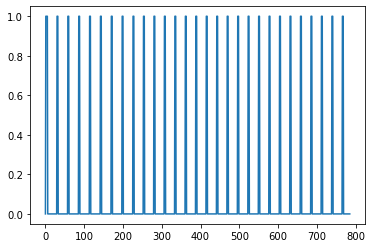

In [19]:
import matplotlib.pyplot as plt
plt.plot(df['on/off'])

In [20]:
p = bokeh.plotting.figure(
    x_axis_label='time (s)',
    y_axis_label='temp (T)',
    frame_height=175,
    frame_width=500,
    x_range=[df['time (sec)'].min(), df['time (sec)'].max()],
)
p.line(source=df, x='time (sec)', y='temp1 (C)')
p.line(source=df, x='time (sec)', y='temp2 (C)')

bokeh.io.show(p)